CNN Model

In [1]:
# conda install pytorch torchvision -c pytorch


# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn

In [2]:
# Check whether GPU is available and choose a device to run the model on
gpu_available = torch.cuda.is_available()
device_name = "cuda" if gpu_available else "cpu"
device = torch.device(device_name)

print(f"Using {device_name}")

Using cuda


Load the real lightcurve data

In [3]:
# Load data

project_folder = Path("C:\\Users\\Miguel\\Google Drive\\self-learning\\ai_saturdays\\project\\saturdays_ai_exoplanets")
data_folder = project_folder/"data"

X_filename = "X_fold_noCentroid_noNans.npy"
y_filename = "y_fold_noCentroid_noNans.npy"
z_filename = "z_fold_noCentroid_noNans.npy"

datanpy    = np.load(data_folder/X_filename)
labelsnpy  = np.load(data_folder/y_filename)
namesnpy   = np.load(data_folder/z_filename)





nof_planets  = (labelsnpy == 1).sum()  # Number of actual planets
nof_falsepos = (labelsnpy == 0).sum()  # Number of false positives

len_global_lightcurves = 2049  # Length of first column of input array, should be odd
len_local_lightcurves  =  257  # Length of second column of input array, should be odd
len_extra_parameters   =    0  # Length of extra parameters for the model input

X = torch.from_numpy(datanpy).float().unsqueeze(1).to(device, dtype=torch.float)
y = torch.from_numpy(labelsnpy).int().to(device, dtype=torch.long)

Let's plot a true positive case from the dataset.

In [53]:
def plot_lightcurves(tensor, status="", object_name="", color="blue"):
    if status == 1:
        label = "planet"
    elif status == 0:
        label = "false positive"
    else:
        label = ""

    output_notebook()
    global_transit_plot = figure(title=f"Global folded lightcurve for {label} {object_name}",
                                 x_axis_label=("Normalized time"), 
                                 y_axis_label=("Normalized light intensity"), 
                                 plot_width=800, plot_height=350)
    global_transit_plot.scatter(
        x=np.linspace(0, 1, len_global_lightcurves), 
        y=tensor[0, :len_global_lightcurves].cpu().numpy().flatten(),
        color=color
                                )

    local_transit_plot = figure(title=f"Local folded lightcurve for {label} {object_name}",
                                x_axis_label=("Normalized time"), 
                                y_axis_label=("Normalized light intensity"), 
                                plot_width=800, plot_height=350)
    local_transit_plot.scatter(
        x=np.linspace(0, 1, len_local_lightcurves), 
        y=tensor[0, len_global_lightcurves:].cpu().numpy().flatten(),
        color=color
                               )


    show(global_transit_plot)
    show(local_transit_plot)

In [55]:
plot_lightcurves(X[0], status=labelsnpy[0], object_name=namesnpy[0])

Loading BokehJS ...

And now a false positive

In [57]:
plot_lightcurves(X[2], status=labelsnpy[2], object_name=namesnpy[2], color="red")

Loading BokehJS ...

In [6]:
# Create an iterable dataset from the input and label tensors
dataset = TensorDataset(X, y)

In [7]:
# Perform the train/test/validation split
train_size = int(0.7 * len(y))
test_size  = int(0.2 * len(y))
val_size = len(y) - train_size - test_size
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
                                             dataset, 
                                             [train_size, test_size, val_size])

In [8]:
# Choose a batch size and create a data loader from the dataset

bs = 50  # Batch size
train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)  # Needs shuffling to prevent correlation between batches
test_dl  = DataLoader(test_dataset,  batch_size=bs * 2)  # Test can use higher batch size because it needs less memory
valid_dl = DataLoader(val_dataset, batch_size=bs * 2)  # Validation can use higher batch size because it needs less memory

In [9]:
class Test_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(8, 8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1)
        self.fc1   = nn.Linear(int((len_global_lightcurves+len_local_lightcurves )/4)*4, 50)
        self.fc2   = nn.Linear(50, 2)
        
    def forward(self, xb):  # xb is of size (1, L)
        
        # Convolutions and pooling
        xb = F.relu(self.conv1(xb))  # Size (8, L)
        xb = F.relu(self.conv2(xb))  # Size (8, L)
        xb = F.relu(self.conv3(xb))  # Size (4, L)
        xb = F.max_pool1d(xb, 4)     # Size (4, floor(L/4))
        
        # Reshape to input the linear layer
        # -1 infers the necessary dimesion from the rest
        xb = xb.view(-1, int(int((len_global_lightcurves+len_local_lightcurves )/4)*4))

        # Apply fully connected layers
        xb = F.relu(self.fc1(xb))    # Size (1, 50)
        xb = self.fc2(xb)            # Size (1, 2)
        
        return xb

In [10]:
class AstroNET_v1(nn.Module):
    def __init__(self, 
                 len_global_lightcurves = 2049, 
                 len_local_lightcurves = 257, 
                 len_extra_parameters = 0,
                 len_fully_connected = 512,
                 input_channels = 1, 
                 output_classes = 2,
                 pooling_type='max'):
        
        super().__init__()
        
        # Pooling dimensional reduction funciton. Order is number of poolings that the
        # column uses. Assumes that:   2*padding = kernel_size-1 and stride = 2
        def pooling_reduction(input_dim, order):
            if order == 1:
                output_dim = int(((input_dim - 1)/2 + 1)//1)
                return output_dim
            else:
                next_dim = int(((input_dim - 1)/2 + 1)//1)
                return pooling_reduction(next_dim, order-1)
        
        
        # General configuration:
        self.input_channels = input_channels
        
        self.len_global_lightcurves = len_global_lightcurves
        self.len_local_lightcurves = len_local_lightcurves
        self.len_extra_parameters = len_extra_parameters
        
        self.len_total_input = (len_global_lightcurves + 
                                len_local_lightcurves + 
                                len_extra_parameters)
        
        self.len_fully_connected = len_fully_connected
        self.output_classes = output_classes
        
                                
        # Calculate the length of the vectors after the convolutional columns
        self.len_global_col = pooling_reduction(self.len_global_lightcurves, 5) * 256
        self.len_local_col  = pooling_reduction(self.len_local_lightcurves, 2) * 32
                                
        # Calculate the input size for the first fully connected layer
        self.len_fc_input = (self.len_global_col + 
                             self.len_local_col + 
                             self.len_extra_parameters * self.input_channels)
        
                                
        # Layers for convolutional columns of the model
        # Layers with same config must be repeated because they will need different weights
        c = self.input_channels
        
        # Convolutions for global view column
        self.conv_5_16_g_a  = nn.Conv1d(  c,  16, kernel_size=5, stride=1, padding=2)
        self.conv_5_16_g_b  = nn.Conv1d( 16,  16, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_32_g_a  = nn.Conv1d( 16,  32, kernel_size=5, stride=1, padding=2)
        self.conv_5_32_g_b  = nn.Conv1d( 32,  32, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_64_g_a  = nn.Conv1d( 32,  64, kernel_size=5, stride=1, padding=2)
        self.conv_5_64_g_b  = nn.Conv1d( 64,  64, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_128_g_a = nn.Conv1d( 64, 128, kernel_size=5, stride=1, padding=2)
        self.conv_5_128_g_b = nn.Conv1d(128, 128, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_256_g_a = nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2)
        self.conv_5_256_g_b = nn.Conv1d(256, 256, kernel_size=5, stride=1, padding=2)
                                
        # Convolutions for local view column   
        self.conv_5_16_l_a  = nn.Conv1d(  c,  16, kernel_size=5, stride=1, padding=2)
        self.conv_5_16_l_b  = nn.Conv1d( 16,  16, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_32_l_a  = nn.Conv1d( 16,  32, kernel_size=5, stride=1, padding=2)
        self.conv_5_32_l_b  = nn.Conv1d( 32,  32, kernel_size=5, stride=1, padding=2)
        
                                
        # Pooling layers
        # These contain no parameters, so they can be shared
        if pooling_type == 'max':
            self.pool_5_2     = nn.MaxPool1d(5, stride=2, padding=2)
            self.pool_7_2     = nn.MaxPool1d(7, stride=2, padding=3)
        elif pooling_type == 'avg':
            self.pool_5_2     = nn.AvgPool1d(5, stride=2, padding=2)
            self.pool_7_2     = nn.AvgPool1d(7, stride=2, padding=3)
        
        # Dense layers for classification of extracted features
        self.fc_512_a     = nn.Linear(self.len_fc_input, self.len_fully_connected)
        self.fc_512_b     = nn.Linear(self.len_fully_connected, self.len_fully_connected)
        self.fc_512_c     = nn.Linear(self.len_fully_connected, self.len_fully_connected)
        self.fc_512_d     = nn.Linear(self.len_fully_connected, self.len_fully_connected)
        
        self.fc_out       = nn.Linear(self.len_fully_connected, self.output_classes)
        
    def forward(self, xb):  # xb is of size (batch_size, input_channels, len_total_input)
        
        batch_size     = xb.size()[0]
        
        # Extract input of different columns for whole batch and all channels
        gb, lb, eb = torch.split(xb, [self.len_global_lightcurves,
                                      self.len_local_lightcurves,
                                      self.len_extra_parameters],
                                 dim=2)
                            
        # Convolutions for global view
        gb = F.relu(self.conv_5_16_g_a (gb))
        gb = F.relu(self.conv_5_16_g_b (gb))
        gb = self.pool_5_2(gb)        
                                
        gb = F.relu(self.conv_5_32_g_a (gb))
        gb = F.relu(self.conv_5_32_g_b (gb))
        gb = self.pool_5_2(gb)                        
                                
        gb = F.relu(self.conv_5_64_g_a (gb))
        gb = F.relu(self.conv_5_64_g_b (gb))
        gb = self.pool_5_2(gb)                        
                                
        gb = F.relu(self.conv_5_128_g_a(gb))
        gb = F.relu(self.conv_5_128_g_b(gb))
        gb = self.pool_5_2(gb)                        
                                
        gb = F.relu(self.conv_5_256_g_a(gb))
        gb = F.relu(self.conv_5_256_g_b(gb))
        gb = self.pool_5_2(gb)
        
        gb = torch.flatten(gb, 1, 2)  # Flatten channels and features but NOT batches
                                
        # Convolutions for local view
        lb = F.relu(self.conv_5_16_l_a (lb))
        lb = F.relu(self.conv_5_16_l_b (lb))
        lb = self.pool_7_2(lb)        
                                
        lb = F.relu(self.conv_5_32_l_a (lb))
        lb = F.relu(self.conv_5_32_l_b (lb))
        lb = self.pool_7_2(lb)
        
        lb = torch.flatten(lb, 1, 2)
                                
        # Reshape extra features
        eb = torch.flatten(eb, 1, 2)
                                
        # Concatenate results maintaining batch positioning in first dimension
        fb = torch.cat((gb, lb, eb), dim=1)

        # Apply fully connected layers
        fb = F.relu(self.fc_512_a(fb))
        fb = F.relu(self.fc_512_b(fb))
        fb = F.relu(self.fc_512_c(fb))
        fb = F.relu(self.fc_512_d(fb))

        # Output layer
        fb = self.fc_out(fb)
        
        return fb

In [11]:
class ExoplaNET_v1(nn.Module):
    def __init__(self, 
                 len_global_lightcurves = 2049, 
                 len_local_lightcurves = 257, 
                 len_secondary_lightcurves = 0, 
                 len_extra_parameters = 0,
                 len_fully_connected = 512,
                 input_channels = 1, 
                 output_classes = 2,
                 dropout = 0.05,
                 pooling_type='max'):
        
        super().__init__()
        
        # Pooling dimensional reduction funciton. Order is number of poolings that the
        # column uses. Assumes that:   2*padding = kernel_size-1 and stride = 2
        def pooling_reduction(input_dim, order):
            if order == 1:
                output_dim = int(((input_dim - 1)/2 + 1)//1)
                return output_dim
            else:
                next_dim = int(((input_dim - 1)/2 + 1)//1)
                return pooling_reduction(next_dim, order-1)
        
        
        # General configuration:
        self.len_global_lightcurves    = len_global_lightcurves
        self.len_local_lightcurves     = len_local_lightcurves
        self.len_secondary_lightcurves = len_secondary_lightcurves
        
        self.len_extra_parameters = len_extra_parameters
        self.input_channels = input_channels
        
        self.len_total_input = (len_global_lightcurves + 
                                len_local_lightcurves + 
                                len_secondary_lightcurves +
                                len_extra_parameters)
        
        self.len_fully_connected = len_fully_connected
        self.output_classes = output_classes
        
                                
        # Calculate the length of the vectors after the convolutional columns
        self.len_global_col     = pooling_reduction(self.len_global_lightcurves,    5) * 256
        self.len_local_col      = pooling_reduction(self.len_local_lightcurves,     2) *  32
        self.len_secondary_col  = pooling_reduction(self.len_secondary_lightcurves, 2) *  32
                                
        # Calculate the input size for the first fully connected layer
        self.len_fc_input = (self.len_global_col + 
                             self.len_local_col + 
                             self.len_secondary_col +
                             self.len_extra_parameters * self.input_channels)
        
                                
        # Layers for convolutional columns of the model
        # Layers with same config must be repeated because they will need different weights
        c = self.input_channels
        
        # Convolutions for global view column
        self.conv_5_16_g_a  = nn.Conv1d(  c,  16, kernel_size=5, stride=1, padding=2)
        self.conv_5_16_g_b  = nn.Conv1d( 16,  16, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_32_g_a  = nn.Conv1d( 16,  32, kernel_size=5, stride=1, padding=2)
        self.conv_5_32_g_b  = nn.Conv1d( 32,  32, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_64_g_a  = nn.Conv1d( 32,  64, kernel_size=5, stride=1, padding=2)
        self.conv_5_64_g_b  = nn.Conv1d( 64,  64, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_128_g_a = nn.Conv1d( 64, 128, kernel_size=5, stride=1, padding=2)
        self.conv_5_128_g_b = nn.Conv1d(128, 128, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_256_g_a = nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2)
        self.conv_5_256_g_b = nn.Conv1d(256, 256, kernel_size=5, stride=1, padding=2)
                                
        # Convolutions for local view column   
        self.conv_5_16_l_a  = nn.Conv1d(  c,  16, kernel_size=5, stride=1, padding=2)
        self.conv_5_16_l_b  = nn.Conv1d( 16,  16, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_32_l_a  = nn.Conv1d( 16,  32, kernel_size=5, stride=1, padding=2)
        self.conv_5_32_l_b  = nn.Conv1d( 32,  32, kernel_size=5, stride=1, padding=2)

        # Convolutions for secondary view column   
        self.conv_5_16_s_a  = nn.Conv1d(  c,  16, kernel_size=5, stride=1, padding=2)
        self.conv_5_16_s_b  = nn.Conv1d( 16,  16, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_32_s_a  = nn.Conv1d( 16,  32, kernel_size=5, stride=1, padding=2)
        self.conv_5_32_s_b  = nn.Conv1d( 32,  32, kernel_size=5, stride=1, padding=2)
                                
        # Pooling layers
        # These contain no parameters, so they can be shared
        if pooling_type == 'max':
            self.pool_5_2     = nn.MaxPool1d(5, stride=2, padding=2)
            self.pool_7_2     = nn.MaxPool1d(7, stride=2, padding=3)
        elif pooling_type == 'avg':
            self.pool_5_2     = nn.AvgPool1d(5, stride=2, padding=2)
            self.pool_7_2     = nn.AvgPool1d(7, stride=2, padding=3)
        
        # Dropout laters
        self.drop = nn.Dropout(dropout)
        
        # Dense layers for classification of extracted features
        self.fc_512_a     = nn.Linear(self.len_fc_input, self.len_fully_connected)
        self.fc_512_b     = nn.Linear(self.len_fully_connected, self.len_fully_connected)
        self.fc_512_c     = nn.Linear(self.len_fully_connected, self.len_fully_connected)
        self.fc_512_d     = nn.Linear(self.len_fully_connected, self.len_fully_connected)
        
        self.fc_out       = nn.Linear(self.len_fully_connected, self.output_classes)
        
    def forward(self, xb):  # xb is of size (batch_size, input_channels, len_total_input)
        
        batch_size     = xb.size()[0]
        
        # Extract input of different columns for whole batch and all channels
        gb, lb, sb, eb = torch.split(xb, [self.len_global_lightcurves,
                                          self.len_local_lightcurves,
                                          self.len_secondary_lightcurves,
                                          self.len_extra_parameters],
                                     dim=2)
        
        if min(gb.size()) > 0:  # Only run the column if the input exists
            # Convolutions for global view
            gb = F.relu(self.conv_5_16_g_a (gb))
            gb = F.relu(self.conv_5_16_g_b (gb))
            gb = self.pool_5_2(gb)
            gb = self.drop(gb)

            gb = F.relu(self.conv_5_32_g_a (gb))
            gb = F.relu(self.conv_5_32_g_b (gb))
            gb = self.pool_5_2(gb)
            gb = self.drop(gb)

            gb = F.relu(self.conv_5_64_g_a (gb))
            gb = F.relu(self.conv_5_64_g_b (gb))
            gb = self.pool_5_2(gb)
            gb = self.drop(gb)

            gb = F.relu(self.conv_5_128_g_a(gb))
            gb = F.relu(self.conv_5_128_g_b(gb))
            gb = self.pool_5_2(gb)
            gb = self.drop(gb)

            gb = F.relu(self.conv_5_256_g_a(gb))
            gb = F.relu(self.conv_5_256_g_b(gb))
            gb = self.pool_5_2(gb)
            gb = self.drop(gb)
        
        gb = torch.flatten(gb, 1, 2)  # Flatten channels and features but NOT batches
        
        if min(lb.size()) > 0:
            # Convolutions for local view
            lb = F.relu(self.conv_5_16_l_a (lb))
            lb = F.relu(self.conv_5_16_l_b (lb))
            lb = self.pool_7_2(lb)    
            lb = self.drop(lb)

            lb = F.relu(self.conv_5_32_l_a (lb))
            lb = F.relu(self.conv_5_32_l_b (lb))
            lb = self.pool_7_2(lb)
            lb = self.drop(lb)

            lb = torch.flatten(lb, 1, 2)
        
        if min(sb.size()) > 0:
            # Convolutions for secondary view
            sb = F.relu(self.conv_5_16_s_a (sb))
            sb = F.relu(self.conv_5_16_s_b (sb))
            sb = self.pool_7_2(sb)
            sb = self.drop(sb)

            sb = F.relu(self.conv_5_32_l_a (sb))
            sb = F.relu(self.conv_5_32_l_b (sb))
            sb = self.pool_7_2(sb)
            sb = self.drop(sb)
        
        sb = torch.flatten(sb, 1, 2)
                                
        # Reshape extra features
        eb = torch.flatten(eb, 1, 2)
                                
        # Concatenate results maintaining batch positioning in first dimension
        fb = torch.cat((gb, lb, sb, eb), dim=1)

        # Apply fully connected layers
        fb = F.relu(self.fc_512_a(fb))
        fb = self.drop(fb)
        fb = F.relu(self.fc_512_b(fb))
        fb = self.drop(fb)
        fb = F.relu(self.fc_512_c(fb))
        fb = self.drop(fb)
        fb = F.relu(self.fc_512_d(fb))

        # Output layer
        fb = self.fc_out(fb)
        
        return fb

In [12]:
def get_model():
    model = Test_CNN()
    return model, optim.SGD(model.parameters(), lr=lr)

In [13]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    # If an optimizer is used, then run as if trianing, otherwise as if testing
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [14]:
def acc_batch(model, xb, yb):
    max_vals, max_indices = torch.max(model(xb), 1)  # Maximum along output dimension (0 is batch dimension)
    accuracy = float((max_indices == yb).sum().float()/len(yb))
    return accuracy, len(yb)

In [15]:
def fit(epochs, model, loss_func, opt, train_dl, test_dl, verbose=True):
    # Initialize the lists were progress will be recorded
    epoch_record, train_loss_record, test_loss_record, test_acc_record = [], [], [], []
    
    # For each epoch, train the model over the whole dataset in batches
    for epoch in range(epochs):
        
        # Training
        model.train()  # Sets the model to training mode
        train_losses, nums = zip(  
            *[loss_batch(model, loss_func, xb, yb, opt) for xb, yb in train_dl]
            )  # Evaluates the cross entropy for each batch and performs backpropagation and step
        train_loss = np.sum(np.multiply(train_losses, nums)) / np.sum(nums)  # Average the individual losses of batches

        # Evaluation
        model.eval()  # Sets the model to evaluation mode (would activate dropout and batchnorm)
        with torch.no_grad():  # This will deactivate the autograd engine and save memory
            test_losses, n_loss = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
                )  # Evaluates the cross entropy for each test batch, but does not backpropagate
            test_accs, n_acc = zip(*[acc_batch(model, xb, yb) for xb, yb in test_dl])  # Calculates accuracy as well
            
        test_loss = np.sum(np.multiply(test_losses, n_loss)) / np.sum(n_loss)  # Average the individual losses in the batch
        test_acc  = np.sum(np.multiply(test_accs,    n_acc)) / np.sum(n_acc )  # Average the individual accuracies in the batch
        
        # Record results for this epoch
        epoch_record.append(epoch)
        train_loss_record.append(train_loss)
        test_loss_record.append(test_loss)
        test_acc_record.append(test_acc)
        
        # Print results for this epoch
        if verbose:
            print(f"Epoch: {(epoch+1):3}    Train loss: {train_loss:7.5f}    Test loss: {test_loss:7.5f}    Test accuracy: {test_acc: 5.3f}")
    
    return epoch_record, train_loss_record, test_loss_record, test_acc_record

In [141]:
learning_rate = 0.05
momentum      = 0.1
epochs        = 100
dropout       = 0.0

loss_func = F.cross_entropy
#model = AstroNET_v1().to(device)
model = ExoplaNET_v1(dropout = dropout
                    ).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [142]:
# Train the model and record the progress at each epoch
epoch_record, train_loss_record, test_loss_record, test_acc_record = fit(
    epochs, model, loss_func, optimizer, train_dl, test_dl)

Epoch:   1    Train loss: 0.63571    Test loss: 0.63442    Test accuracy:  0.670
Epoch:   2    Train loss: 0.62677    Test loss: 0.63436    Test accuracy:  0.670
Epoch:   3    Train loss: 0.62679    Test loss: 0.63441    Test accuracy:  0.670
Epoch:   4    Train loss: 0.62675    Test loss: 0.63448    Test accuracy:  0.670
Epoch:   5    Train loss: 0.62664    Test loss: 0.63494    Test accuracy:  0.670
Epoch:   6    Train loss: 0.62682    Test loss: 0.63501    Test accuracy:  0.670
Epoch:   7    Train loss: 0.62662    Test loss: 0.63435    Test accuracy:  0.670
Epoch:   8    Train loss: 0.62647    Test loss: 0.63502    Test accuracy:  0.670
Epoch:   9    Train loss: 0.62668    Test loss: 0.63495    Test accuracy:  0.670
Epoch:  10    Train loss: 0.62664    Test loss: 0.63489    Test accuracy:  0.670
Epoch:  11    Train loss: 0.62665    Test loss: 0.63444    Test accuracy:  0.670
Epoch:  12    Train loss: 0.62649    Test loss: 0.63448    Test accuracy:  0.670
Epoch:  13    Train loss: 0.

In [143]:
output_notebook()
loss_plot = figure(x_axis_label=("Epoch"), 
                   y_axis_label=("Cross-entropy loss"), 
                   plot_width=800, plot_height=350)
loss_plot.line(
    x=epoch_record, 
    y=test_loss_record,
    color="blue",
    line_width=2, alpha=0.8, legend_label="Test Loss"
               )
loss_plot.line(
    x=epoch_record, 
    y=list(train_loss_record),
    color="orange",
    line_width=2, alpha=0.8, legend_label="Training Loss"
               )

loss_plot.line(
    x=epoch_record, 
    y=list(test_acc_record),
    color="green",
    line_width=2, alpha=0.8, legend_label="Accuracy"
               )

show(loss_plot)

Loading BokehJS ...

In [65]:
valid_dl = DataLoader(val_dataset, batch_size=50)

val_losses = [loss_batch(model, loss_func, xb, yb, opt=None)[0] for xb, yb in valid_dl]
val_accurs = [acc_batch(model, xb, yb)[0] for xb, yb in valid_dl]
print(f"Validation cross entropy loss: {sum(val_losses)/len(val_losses)}")
print(f"Validation accuracy: {sum(val_accurs)/len(val_accurs)}")

Validation cross entropy loss: 0.44154249839484694
Validation accuracy: 0.90933332045873


In [115]:
from scipy.special import softmax

valid_dl = DataLoader(val_dataset, batch_size=1)
val_results, val_labes = [], []
for xb, yb in valid_dl:
    val_results.append(softmax(model(xb).cpu().detach().numpy()))
    val_labes.append(yb.cpu().detach().numpy())
val_results = np.concatenate(val_results)[:, 1]
val_labels   = np.concatenate(val_labes)

val_asig = np.stack([val_results, val_labels], axis=1)

In [118]:
val_diff = np.abs(val_asig[:, 0] - val_asig[:, 1])

(array([611.,  17.,   5.,  10.,   1.,   4.,   9.,   4.,   6.,  45.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

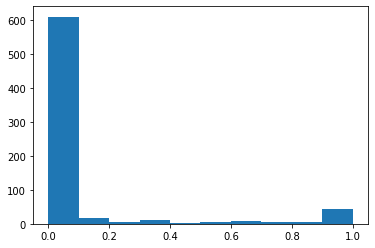

In [123]:
import matplotlib.pyplot as plt
plt.hist(val_diff)

In [135]:
precision = []
recall = []
truths = val_asig[:, 1] == 1.
num_truths = truths.sum()
for threshold in np.linspace(0, 1, 100001)[:-1]:
    assignations = val_asig[:, 0] > threshold
    num_positives = assignations.sum()
    true_positives = (assignations & truths)
    num_true_positives = true_positives.sum()
    
    precision.append(num_true_positives / num_positives if num_positives > 0 else 1)
    recall.append(num_true_positives / num_truths if num_truths > 0 else 1)
    

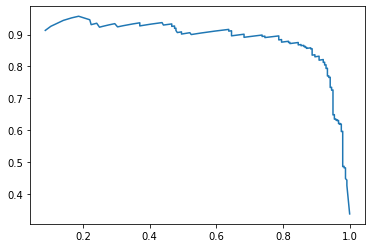

In [136]:
plt.plot(recall, precision)

In [139]:
def auc_calculator(assignations, samples = 1e5):
    """Calculates the probability that a randomly chosen
    planet scores higher in the model than a randomly 
    chosen false positive.
    """
    trues = assignations[:,0][assignations[:,1] == 1]
    falses = assignations[:,0][assignations[:,1] == 0]
    successes = 0
    for sample in range(int(samples)):
        true_sample = np.random.choice(trues)
        false_sample = np.random.choice(falses)
        if true_sample > false_sample:
            successes += 1
    return successes / samples

In [140]:
auc_calculator(val_asig)

0.9503

In [21]:
models_folder = project_folder/"models"

torch.save(model.state_dict(), "exonet_trained_real_dropouts.pt")
torch.save(optimizer.state_dict(), "exonet_trained_real_dropouts.opt")